In [51]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(dplyr)
library(GGally)

Title: The exploration of the "User knowledge" database

Introduction:

User modeling involves creating an imitation of the conceptual understanding of a user, which can be utilized to improve the customization and system interfaces to fit a user’s needs. This serves as a cheaper and more efficient alternative to user testing. In this particular user model, a dataset is used to predict the exam scores of users. This dataset includes five attributes, STG (The degree of study time for goal object materials), SCG (The degree of repetition number of user for goal object materials), STR (The degree of study time of user for related objects with goal object), LPR (The exam performance of user for related objects with goal object), and PEG (The exam performance of user for goal objects). We hypothesized that there is a relationship between degree of study time, repetition, exam performances and UNS (the knowledge level of the user). We will use data analysis to check if our hypothesis is correct by using STG, SCG, and PEG to predict UNS. 
The dataset we will use: “User Knowledge” Dataset.
Training_data: 259 rows of data with the first row being the title, the five attributes (STG, SCG, STR, LPR, PEG) each contains a value between 0 and 1, the target value UNS has four classifications (very low, low, middle, high). 
Testing_data: 146 rows of data with the first row being the title, the five attributes (STG, SCG, STR, LPR, PEG) each contains a value between 0 and 1, the target value UNS has four classifications (very low, low, middle, high).


Preliminary Exploratory data analysis:


User modeling involves creating an imitation of the conceptual understanding of a user, which can be utilized to improve the customization and system interfaces to fit a user’s needs. This serves as a cheaper and more efficient alternative to user testing. In this particular user model, a dataset is used to predict the exam scores of users. This dataset includes five attributes, STG (The degree of study time for goal object materials), SCG (The degree of repetition number of user for goal object materials), STR (The degree of study time of user for related objects with goal object), LPR (The exam performance of user for related objects with goal object), and PEG (The exam performance of user for goal objects). We hypothesized that there is a relationship between degree of study time, repetition, exam performances and UNS (the knowledge level of the user). We will use data analysis to check if our hypothesis is correct by using STG, SCG, and PEG to predict UNS. 

The dataset we will use: “User Knowledge” Dataset

Training_data: 259 rows of data with the first row being the title, the five attributes (STG, SCG, STR, LPR, PEG) each contains a value between 0 and 1, the target value UNS has four classifications (very low, low, middle, high). 

Testing_data: 146 rows of data with the first row being the title, the five attributes (STG, SCG, STR, LPR, PEG) each contains a value between 0 and 1, the target value UNS has four classifications (very low, low, middle, high). 


In [52]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", destfile = "dataset.xls")
set.seed(2022)
training_original <- read_excel("dataset.xls", sheet = 2)
testing_original <- read_excel("dataset.xls", sheet = 3)

tidy_testing_original <- select(testing_original, STG:UNS)
tidy_training_original <- select(training_original, STG:UNS)
tidy_user_data_original <- bind_rows(tidy_testing_original, tidy_training_original)

New names:
• `` -> `...7`
• `` -> `...8`
New names:
• `` -> `...7`
• `` -> `...8`


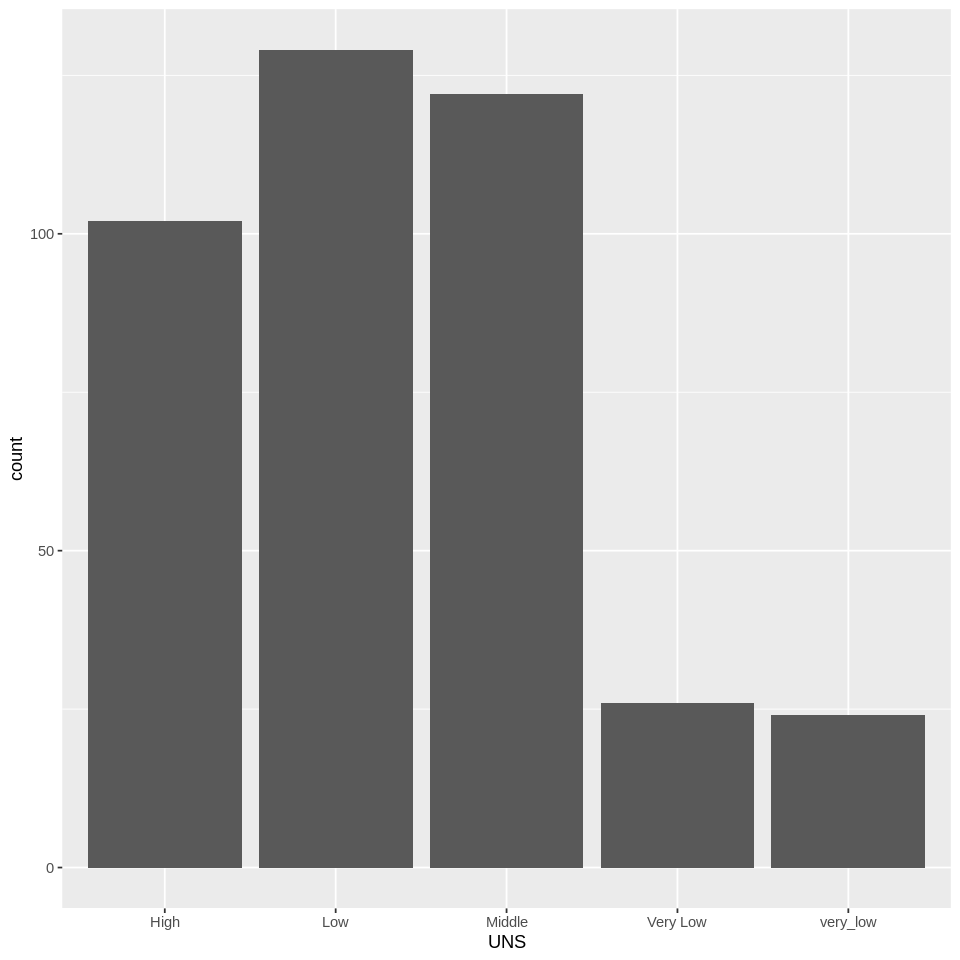

In [53]:
user_data_original_plot <- tidy_user_data_original |>
    ggplot(aes(x=UNS)) +
    geom_bar()
user_data_original_plot

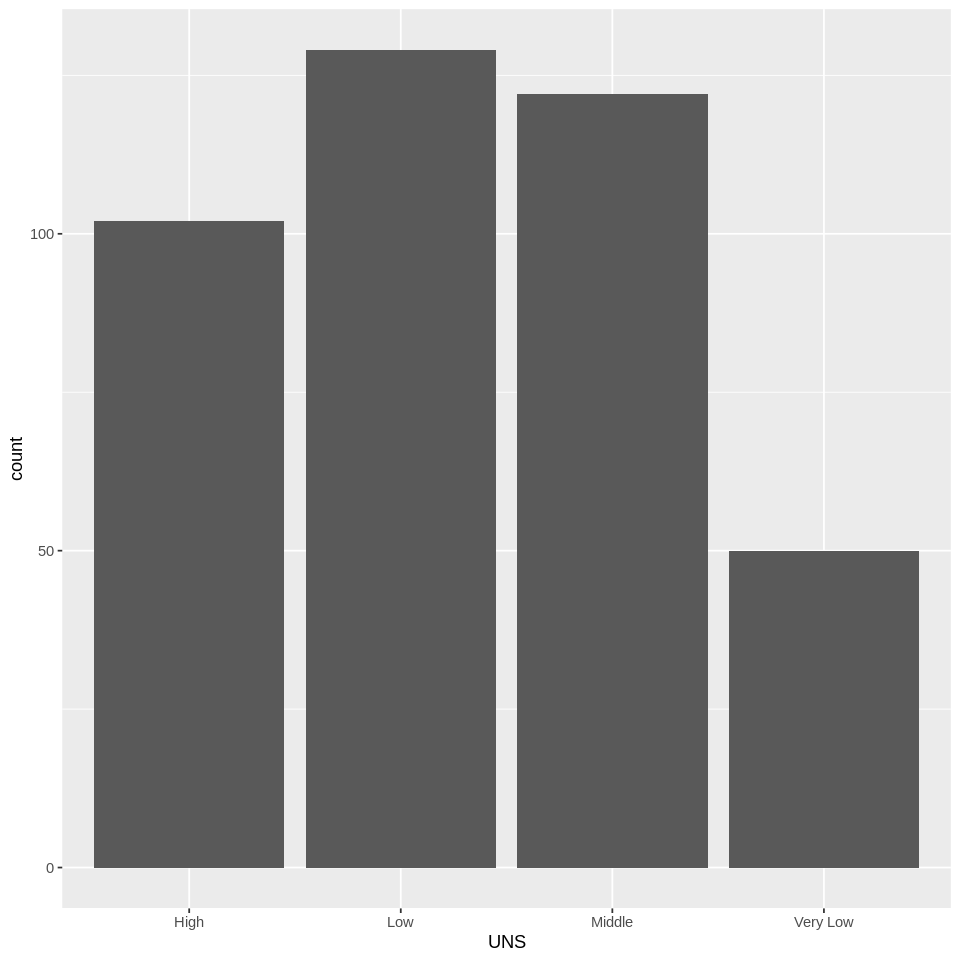

In [54]:
df1 <- tidy_user_data_original |>
    filter(UNS == "very_low") |>
    mutate(UNS = "Very Low")
df2 <- tidy_user_data_original |>
    filter(UNS != "very_low")
user_data <- bind_rows(df1, df2)

user_data <- mutate(user_data, UNS = as.factor(UNS))

user_data_original_plot2 <- user_data |>
    ggplot(aes(x=UNS)) +
    geom_bar()
user_data_original_plot2

In [55]:
user_split <- initial_split(user_data, prop=0.75, stata = UNS)
training <- training(user_split)
testing <- testing(user_split)
head(training)
head(testing)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.240,0.580,0.76,0.80,0.28,Middle
0.200,0.490,0.60,0.20,0.78,High
0.475,0.320,0.79,0.31,0.54,Middle
0.365,0.680,0.10,0.63,0.18,Low
0.120,0.245,0.75,0.31,0.59,Middle
0.290,0.300,0.56,0.25,0.67,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.150,0.020,0.34,0.40,0.01,Very Low
0.290,0.150,0.33,0.66,0.08,Very Low
0.251,0.265,0.57,0.60,0.09,Very Low
0.265,0.600,0.28,0.66,0.07,Very Low
0.590,0.180,0.31,0.55,0.09,Very Low
0.600,0.190,0.55,0.08,0.10,Very Low


Forward Selection

In [56]:
set.seed(3)
names <- colnames(training |> select (-UNS))
names
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
user_vfold <- vfold_cv(training, v = 5, strata = UNS)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

[1] "STG" "SCG" "STR" "LPR" "PEG"

In [57]:
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        user_recipe <- recipe(as.formula(model_string), 
                                data = training) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(user_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = user_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
     names <- names[-jstar]}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,UNS ~ PEG,0.8344578
2,UNS ~ PEG+LPR,0.9635917
3,UNS ~ PEG+LPR+SCG,0.9601435
4,UNS ~ PEG+LPR+SCG+STG,0.9275663
5,UNS ~ PEG+LPR+SCG+STG+STR,0.8350156


Methods:
Our group will use STG, SCG, PEG, and UNS to do the data analysis. We plan to use K-nearest neighbors classification to visualize the results. STC, SCG, and PEG will be used as predictors to predict UNS.

Cross-validation 

In [45]:
set.seed(2022)
user_knowledge_recipe <- recipe(UNS ~ PEG + LPR, data = training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
user_knowledge_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Parameter value choose

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9537521,5,0.007910343,Preprocessor1_Model1
4,accuracy,multiclass,0.9603716,5,0.012398960,Preprocessor1_Model2
5,accuracy,multiclass,0.9669836,5,0.010416562,Preprocessor1_Model3
6,accuracy,multiclass,0.9669836,5,0.010416562,Preprocessor1_Model4
8,accuracy,multiclass,0.9669836,5,0.010416562,Preprocessor1_Model5
10,accuracy,multiclass,0.9603169,5,0.016282406,Preprocessor1_Model6
11,accuracy,multiclass,0.9504809,5,0.013913187,Preprocessor1_Model7
13,accuracy,multiclass,0.9504809,5,0.013913187,Preprocessor1_Model8
14,accuracy,multiclass,0.9504809,5,0.013913187,Preprocessor1_Model9


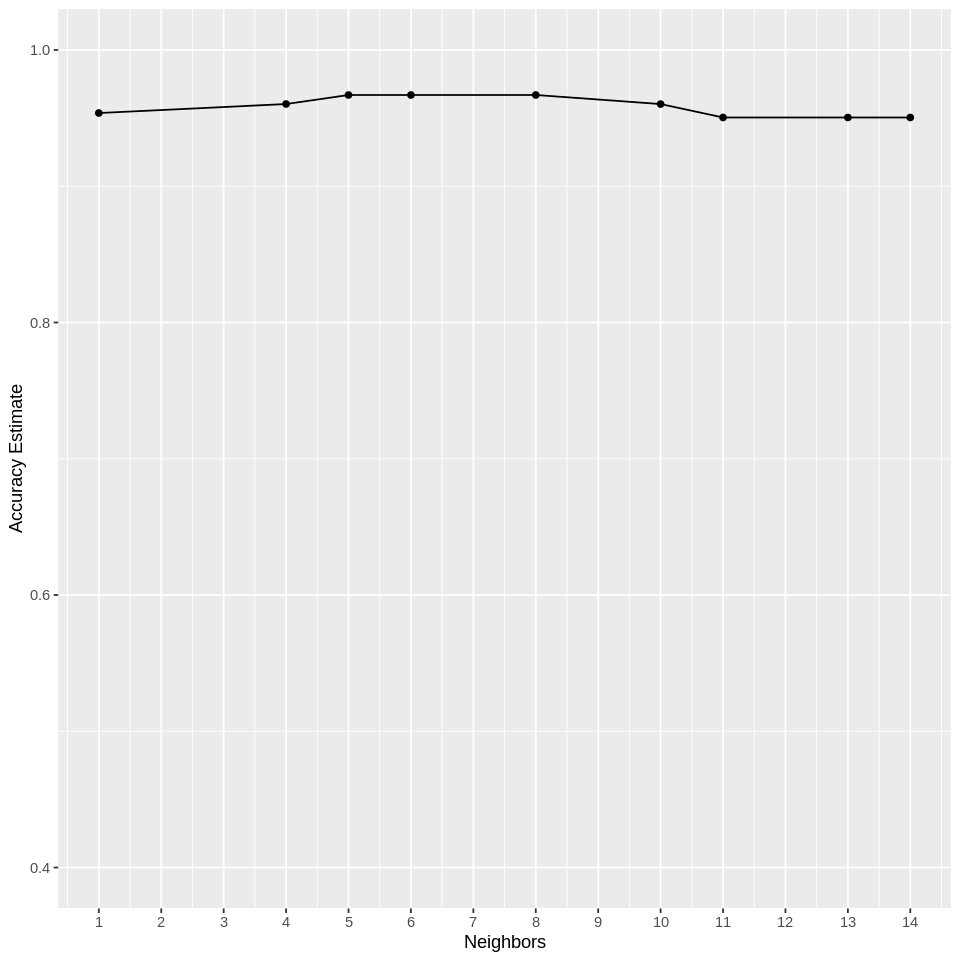

In [59]:
set.seed(2022)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

user_knowledge_vfold <- vfold_cv(training, v = 5, strata = UNS)

knn_results <- workflow() |>
    add_recipe(user_knowledge_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = user_knowledge_vfold, grid = 10) |>
    collect_metrics()



accuracies <- knn_results |> 
    filter(.metric == "accuracy")
accuracies
options(repr.plot.height = 8, repr.plot.width = 8)
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +  
    scale_y_continuous(limits = c(0.4, 1.0)) 
accuracy_versus_k


From this graph we can see that when k=4, the accuracy is the highest. So, we will choose k=4 for prediction.

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,multiclass,0.9603716,5,0.012398960,Preprocessor1_Model1
roc_auc,hand_till,0.9850425,5,0.005263988,Preprocessor1_Model1


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Training data contained 403 data points and no missing data.

Operations:

Scaling for PEG, LPR [trained]
Centering for PEG, LPR [trained]

PEG,LPR,UNS
<dbl>,<dbl>,<fct>
-1.710652,-1.6748240,Very Low
-1.673167,-0.1216969,Very Low
-1.523228,-1.6359958,Very Low
-1.335804,-0.7041196,Very Low
-1.710652,-0.6652914,Very Low
-1.560713,-0.6264632,Very Low


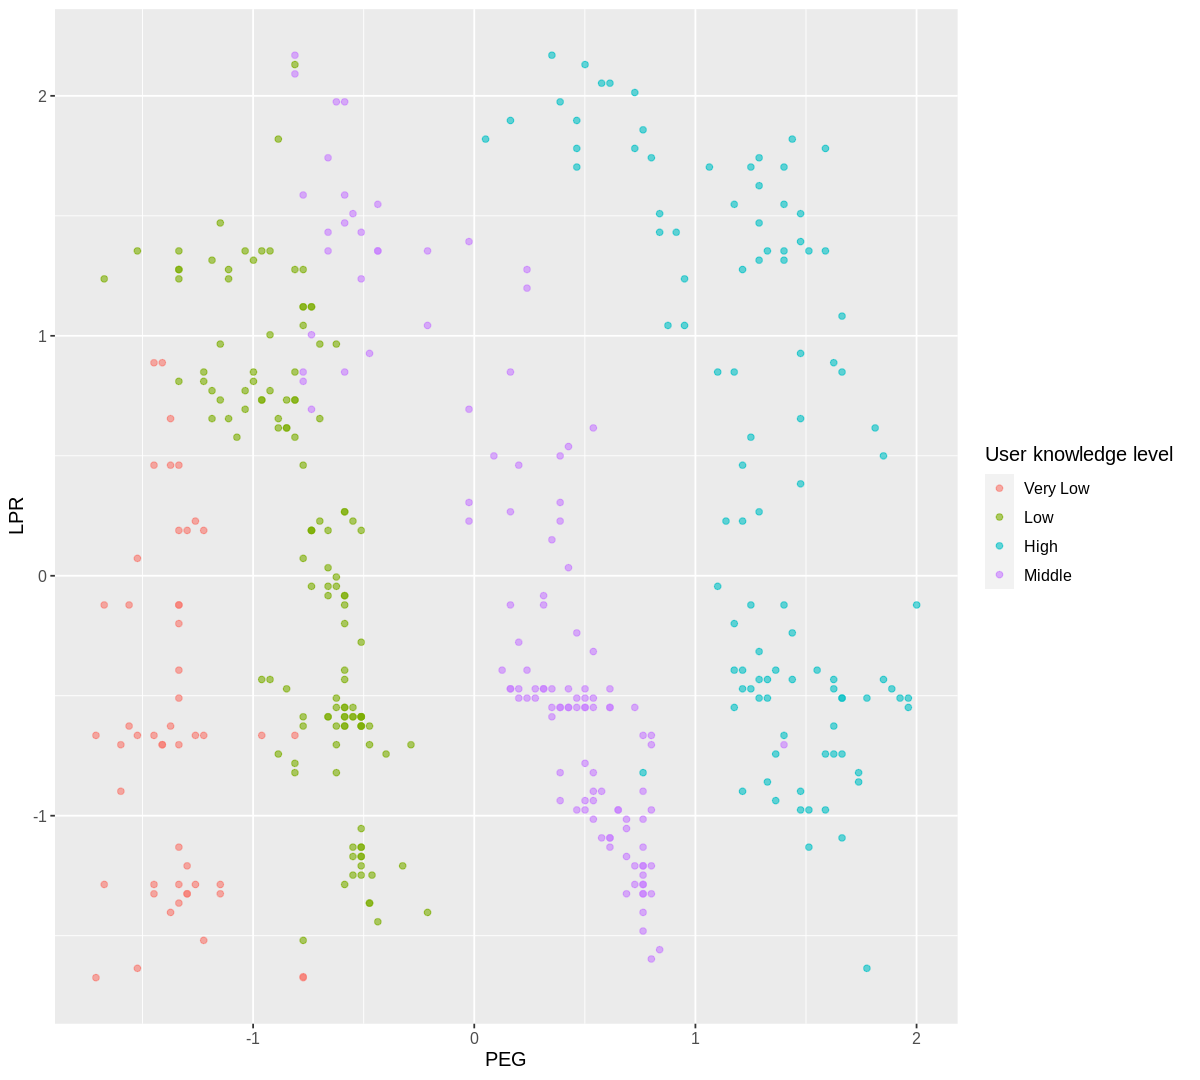

In [17]:
set.seed(2022)
user_knowledge_vfold <- vfold_cv(training, v = 5, strata = UNS)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn")%>%
    set_mode("classification")

user_knowledge_resample_fit <- workflow() %>%
add_recipe(user_knowledge_recipe) %>%
add_model(knn_spec) %>%
fit_resamples(resamples = user_knowledge_vfold)
user_knowledge_metrics <- collect_metrics(user_knowledge_resample_fit)
user_knowledge_metrics


unscaled_new_user_data <- user_data%>%mutate(UNS=as_factor(UNS))%>%select(PEG,LPR,UNS)
uc_recipe <- recipe(UNS~PEG+LPR,data=unscaled_new_user_data)
uc_recipe <- uc_recipe%>%step_scale(all_predictors())%>%step_center(all_predictors())%>%prep()
uc_recipe
scaled_new_user_data <- bake(uc_recipe, unscaled_new_user_data)
head(scaled_new_user_data)
options(repr.plot.width=10, repr.plot.height=9)
plot <- scaled_new_user_data%>%ggplot(aes(x=PEG,y=LPR,color=UNS))+geom_point(alpha=0.6)+labs(x="PEG",y="LPR",color="User knowledge level")+theme(text=element_text(size=12))
plot

In [50]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")
user_knowledge_fit <- workflow() |>
    add_recipe(user_knowledge_recipe) |>
    add_model(knn_spec) |>
    fit(data = training)
user_knowledge_test_predictions <- predict(user_knowledge_fit, testing) |>
    bind_cols(testing)

user_knowledge_mat <- user_knowledge_test_predictions |>
    conf_mat(truth = UNS, estimate = .pred_class)
user_knowledge_mat

          Truth
Prediction High Low Middle Very Low
  High       22   0      0        0
  Low         0  34      0        2
  Middle      0   0     33        0
  Very Low    0   0      0       10

Then, we will calculate the distances between our new observation(UNS) and each of the observations in the training set tp find the K=5 neighbors when we have PEG and LPR as predictors.

We choose high value of PEG and LPR first to see what the new observation will be.

In [ ]:
new_obs_PEG <- 1.5 
new_obs_LPR <- 1.5
scaled_new_user_data %>% select(PEG, LPR, UNS)%>%mutate(dist_from_new=sqrt((PEG-new_obs_PEG)^2+(LPR-new_obs_LPR)^2))%>%arrange(dist_from_new)%>%slice(1:5)


We can see that when PEG and LPR are high, the user will have a high probability to be high knowledge level.

Next, we choose low value of PEG and LPR to see what the new observation will be.

In [ ]:
new_obs_PEG <- 0.7 
new_obs_LPR <- 0.7
scaled_new_user_data %>% select(PEG, LPR, UNS)%>%mutate(dist_from_new=sqrt((PEG-new_obs_PEG)^2+(LPR-new_obs_LPR)^2))%>%arrange(dist_from_new)%>%slice(1:5)


We can see that when PEG and LPR are low, the probability for users to have high knowledge level decreases.

Expected outcomes and significance: We expect to use STC, SCG, and PEG as predictors to predict the knowledge level of this user. When we can predict the knowledge level of a user, we can match the suitable learning objects and methods to the needs of the users/students to help them learn more effectively. This finding can allow for personalized education, allowing users to improve their academic performance and achieve their potential. This is much more efficient than one-size-fits-all systems. Future questions this project could lead to include predicting different study methods and strategies tailored to a user’s mannerisms.
 


In [ ]:
accuracies